In [1]:
# Modify the file A00_setup.  Note the working directory is changed
import os
os.chdir(os.getcwd().rsplit(os.path.sep + 'code')[0] + os.path.sep + 'code')
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./A_target_count_encoding/A00_setup.py").load_module()
os.getcwd()

'/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code'

# XGBoost with Mean Encodings of all Hierarchical Levels
Include all levels of encodings.  This is an additional baseline for hierarchical or target-mean encoding.

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot, sg_blender
from sba_gnn.sba_gnn.sg_blender import HierarchicalEncoder # Target encoder

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.parent_path).joinpath('01_DATA_transformed.parquet')) 

##### Append DGI info

In [7]:
##### DGI info
embed_df = pd.read_parquet(Path(setup.parent_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

In [8]:
# Group counts
naics_grp_counts = pd.read_csv(Path(setup.parent_path).joinpath('02_REPORT_naics_grp_stats_all.csv')) \
    [['level_0', 'count_grp']] \
    .drop_duplicates() \
    .set_axis(['naics_type', 'k'], axis=1)

In [9]:
naics_grp_k = naics_grp_counts['k'].drop_duplicates().sort_values().to_list()
naics_grp_k

[20.0, 106.0, 354.0, 834.0]

In [10]:
cluster_cols = sorted([c for c in embed_df if c.startswith('cluster_')],
                      reverse=True)
cluster_cols

['cluster_834',
 'cluster_354',
 'cluster_106',
 'cluster_020',
 'cluster_010',
 'cluster_003']

In [11]:
cluster_cols_sel = sorted([c for c in cluster_cols if int(c.split('_')[1]) in naics_grp_k],
                         reverse=True)
cluster_cols_sel

['cluster_834', 'cluster_354', 'cluster_106', 'cluster_020']

In [12]:
enc_cols = ['NAICS'] + cluster_cols_sel

In [13]:
sba_loans = sba_loans.drop(columns = cluster_cols_sel, errors='ignore') \
    .merge(embed_df[['NAICS_orig'] + cluster_cols_sel] \
               .rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS', how='left')

In [14]:
train_df = sba_loans[sba_loans['dset'] == 'train']

#### Encode the features

In [15]:
# Create encoders
enc_dict = {f:HierarchicalEncoder(lambda_k = setup.selected_lambda_k) for f in enc_cols}

In [16]:
# fit encoders
[enc_dict[f].fit(train_df[[f]], train_df['target']) for f in enc_cols]

[None, None, None, None, None]

In [17]:
with open(Path(setup.temp_path).joinpath('A25_DATA_encoder.pkl'), 'wb') as fout:
    pickle.dump(enc_dict, fout)

In [18]:
# Transform the data
enc_val = pd.concat([enc_dict[f].transform(sba_loans[[f]]) for f in enc_cols],
                    axis=1, keys=enc_cols)
enc_val.columns = ['menc_' + c for c in enc_val.columns]

In [19]:
predictor_features = setup.predictor_features + list(enc_val.columns)
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'menc_NAICS', 'menc_cluster_834', 'menc_cluster_354', 'menc_cluster_106', 'menc_cluster_020']


In [20]:
with open(Path(setup.temp_path).joinpath('A25_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

In [21]:
# Save the values
pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']] \
               .drop(columns=enc_val.columns, errors='ignore'), enc_val], axis = 1) \
    .to_parquet(Path(setup.temp_path).joinpath('A25_DATA_encodings.parquet'))

In [22]:
sba_loans = pd.concat([sba_loans.drop(columns=enc_val.columns, errors='ignore'), enc_val], 
                      axis=1)
print(sba_loans.shape)

(688081, 66)


In [23]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

## Model Fit

In [24]:
best_params_df = pd.read_csv(Path(setup.parent_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [25]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [26]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators =  setup.xgb_n_estimators)

In [27]:
xgb_model = xgb_model.set_params(**xgb_params)

In [28]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.50030	validation_1-logloss:0.50382
[1]	validation_0-logloss:0.49274	validation_1-logloss:0.49649
[2]	validation_0-logloss:0.48636	validation_1-logloss:0.49033
[3]	validation_0-logloss:0.48098	validation_1-logloss:0.48514
[4]	validation_0-logloss:0.47643	validation_1-logloss:0.48084
[5]	validation_0-logloss:0.47246	validation_1-logloss:0.47703
[6]	validation_0-logloss:0.46911	validation_1-logloss:0.47386
[7]	validation_0-logloss:0.46622	validation_1-logloss:0.47114
[8]	validation_0-logloss:0.46378	validation_1-logloss:0.46889
[9]	validation_0-logloss:0.46164	validation_1-logloss:0.46693
[10]	validation_0-logloss:0.45973	validation_1-logloss:0.46520
[11]	validation_0-logloss:0.45817	validation_1-logloss:0.46379
[12]	validation_0-logloss:0.45672	validation_1-logloss:0.46246
[13]	validation_0-logloss:0.45547	validation_1-logloss:0.46135
[14]	validation_0-logloss:0.45441	validation_1-logloss:0.46040
[15]	validation_0-logloss:0.45340	validation_1-logloss:0.45950
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
train_df['target'].value_counts()

target
0    346866
1     89254
Name: count, dtype: int64

##### Save the model

In [30]:
xgb_model.save_model(Path(setup.temp_path).joinpath('A25_MODEL_xgboost.json'))

In [31]:
with open(Path(setup.temp_path).joinpath('A25_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [32]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [33]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.185716,0.115079,0.014985,0.675935,0.170838
1,0.285427,0.110071,0.015190,0.678942,0.291203


## Decision Threshold
Max f1, on training data

In [34]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [35]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [36]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('A25_REPORT_thresh_tune.csv'), index=False)

In [37]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.456832
11,0.22,0.456119


##### Apply decision threshold
All datasets

In [38]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [39]:
pred_df['predict_bin'].value_counts()

predict_bin
0    402436
1    285645
Name: count, dtype: int64

In [40]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('A25_DATA_combined_predictions.parquet'))

## Metrics

In [41]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('A25_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.648167,0.435627,0.317589,0.693306,0.365440,0.725540,NaN
1,train,0.665338,0.456832,0.342023,0.687667,0.395868,0.737775,NaN
2,val,0.661095,0.452155,0.340170,0.674059,0.388881,0.728220,NaN
0,test,0.660361,0.450591,0.337639,0.677106,0.384407,0.729448,0.0
1,test,0.630649,0.414561,0.291136,0.719651,0.331534,0.719168,1.0


## Lift
Test data

In [42]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

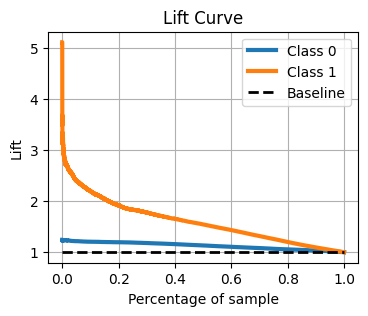

In [43]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A25_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [44]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [45]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('A25_REPORT_importance_gain.csv'), index=True)

In [46]:
feat_impgain.head()

,importance
urban_flag,320.598816
menc_NAICS,188.045837
LowDoc,144.525650
DisbursementGross,55.309689
franchise_flag,23.689053


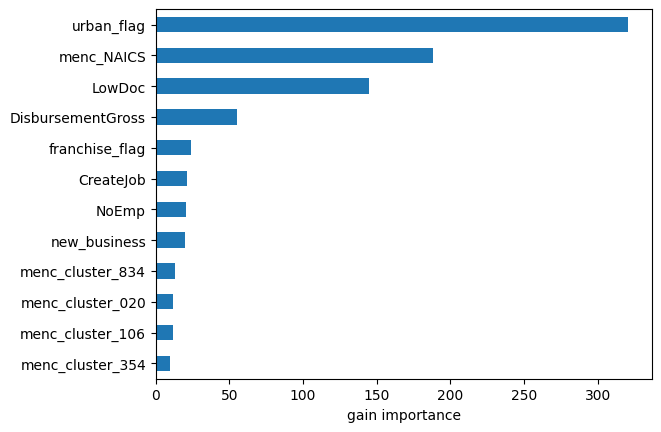

In [47]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('A25_PLOT_importance_gain.png'))

##### Permutation Importance

In [48]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [49]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [50]:
perm_importance_df.head(5)

,features,importance,abs_importance
7,menc_NAICS,0.090358,0.090358
3,DisbursementGross,0.067399,0.067399
5,urban_flag,0.036018,0.036018
1,CreateJob,0.019175,0.019175
2,LowDoc,0.014633,0.014633


In [51]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('A25_DATA_importance_perturb.csv'),
            index=False)

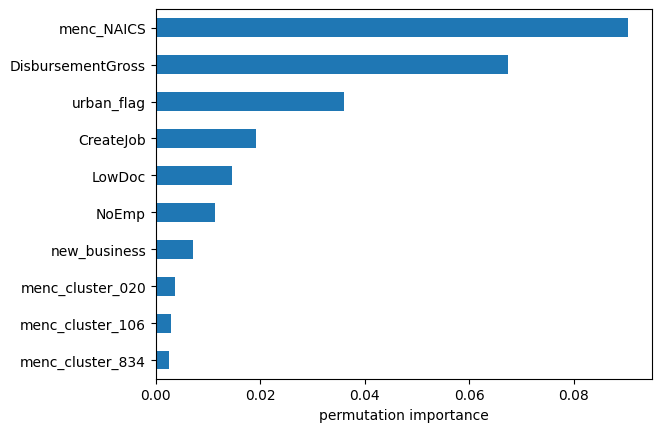

In [52]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('A25_PLOT_importance_perturb.png'))

## PDP Plot

In [53]:
feat_list = list(enc_val.columns)

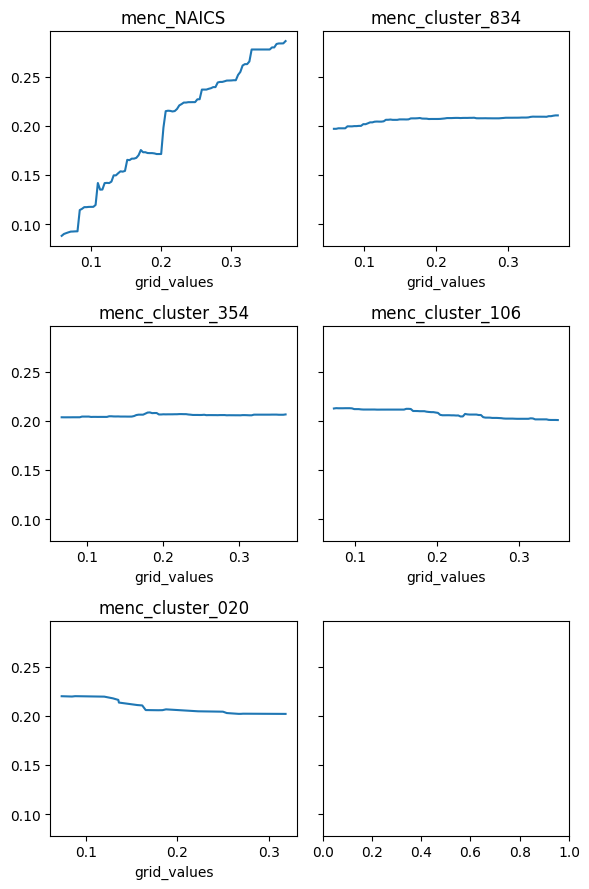

In [54]:
fig, ax = plt.subplots(int(np.ceil(len(feat_list)/2)), 2, sharex=False, 
                       sharey=True, figsize=(6, 9))
for i in range(len(feat_list)):
    col = int(i % 2)
    row = int(np.floor(i / 2))
    try:
        results = partial_dependence(xgb_model, train_df[predictor_features], 
                                     [feat_list[i]])
    except:
        continue
    pdp_df = pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})
    pdp_df.plot(x='grid_values', y='pdp', legend=None, ax=ax[row, col])
    ax[row, col].set_title(feat_list[i])

fig.tight_layout()
fig.savefig(Path(setup.temp_path).joinpath('A25_PLOT_pdp_combined.png'),
               bbox_inches='tight')
plt.show()